In [1]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# random forest classifier
from sklearn.ensemble import RandomForestClassifier

# split train and test set
from sklearn.model_selection import train_test_split

# upsamling (if needed)
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTENC
from imbens.sampler._over_sampling import RandomOverSampler 

# Method overview

## Predictor variables

## Climate niche

## Target variabe 'High risk'

## Model
Construct basic random forest following https://www.kaggle.com/code/prashant111/random-forest-classifier-tutorial/notebook

## Handling of class imbalance

## Calculate feature importance
Calculate feature importance based on full model permutation importance:
https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

In [94]:
### Prepare dataset ###
# load dataset
pred2022 = pd.read_csv('pred2022.csv')

# remove aceecriterion B: Small, declining or fluctuating geographic range
pred2022.loc[(~ pred2022['2022 Red List Criteria'].fillna('o').str.contains('B'))]

# define target variable higher risk
uplisted1234 = ((pred2022['2004-2022 Genuine Change?'] == 'Genuine - uplisted') &
                (pred2022['2004 RL num'] < 5)).values * 1
not_downlisted56 = ((pred2022['2004-2022 Genuine Change?'] != 'Genuine - downlisted') &
                   (pred2022['2004 RL num'] >= 5)).values * 1

pred2022['higher risk'] = uplisted1234 + not_downlisted56

# drop non-numerical and unwanted columns
x = pred2022.drop(['Unnamed: 0', 'Species Name', 'Family', 'Species Name_x', 'Species_x', 'Species_y',
       '2004 GAA2 Red List Category', '2022 GAA2 Red List Category',
       '2022 Red List Criteria', '2004-2022 Genuine Change?',
       ' 2004-2022 Primary Driver', 'Grouped 2004-2022 Primary Driver',
       '2004-2022 Genuine downlisting due to conservation', '2022 RL num', 'Species Name_y'], axis=1)

# define categorical features
c_features = ['Order', 'Afrotropical', 'Australasian/Oceanian', 'Indomalayan',
       'Nearctic', 'Neotropical', 'Palearctic', 'N_realm', 'SemiAqua',
       'Generalist', 'Other', '2004 RL num']

# # drop highly corelated features (optional)
# x = x.drop(['urbanareas_2021_change', 'MAT_2022', 'AP_2022', 'MTWM_2022' ,'MTWM_change_2022','MTWM_nichefrac_2022' , 'MTCM_2022', 'MTCM_change_2022','MTCM_nichefrac_2022', 'PDQ_2022', 'PDQ_change_2022'], axis=1) 

# drop features that were contained in IUCN data to avoid circularity (optional)
# x = x.drop(['Egg Laying', 'Free Living Larval Stage', 'Live Birth ',
#        'Water Breeding', 'Bd (ongoing)', 'Bsal (ongoing)', 'Invasive species'], axis=1)

# drop nan values
x = x.dropna()


Entries per order and red list category (2004):


SUM ORDER    LC   NT   VU   EN   CR   EX
sum red list category      3876  2274  224  399  571  307  101
ANURA                      3418  2082  174  343  469  252   98
CAUDATA                     409   159   46   52   96   53    3
GYMNOPHIONA                  49    33    4    4    6    2    0


High risk entries per order and red list category (2004):


SUM ORDER  LC  NT  VU  EN   CR   EX
sum red list category       537  65  32  28  22  289  101
ANURA                       450  51  24  23  19  235   98
CAUDATA                      84  14   7   5   3   52    3
GYMNOPHIONA                   3   0   1   0   0    2    0



Data variables:
1. Generalist
2. Other
3. Body_size_mm
4. 2004 RL num
5. urbanareas_2021
6. cropland_2021
7. rangeland_2021
8. managed_pasture_2021
9. urbanareas_2021_change
10. cropland_2021_change
11. rangeland_2021_change
12. managed_pasture_2021_change
13. area_2021
14. travel_time_2015
15. population_density_2021
16. population_density_change_2021
17. MAT_nichefrac_2022
18. MAT_2022
19. MAT_change_2022
20. MTWM_nichefrac_2022
21. MTWM_2022
22. MTWM_change_2022
23. MTCM_nichefrac_2022
24. MTCM_2022
25. MTCM_change_2022
26. AP_nichefrac_2022
27. AP_2022
28. AP_change_2022
29. PDQ_nichefrac_2022
30. PDQ_2022
31. PDQ_change_2022
32. Bd (ongoing)
33. Bsal (ongoing)
34. Invasive species
35. higher risk

Categorical variables (counts, high risk counts and percentage of high risk species):


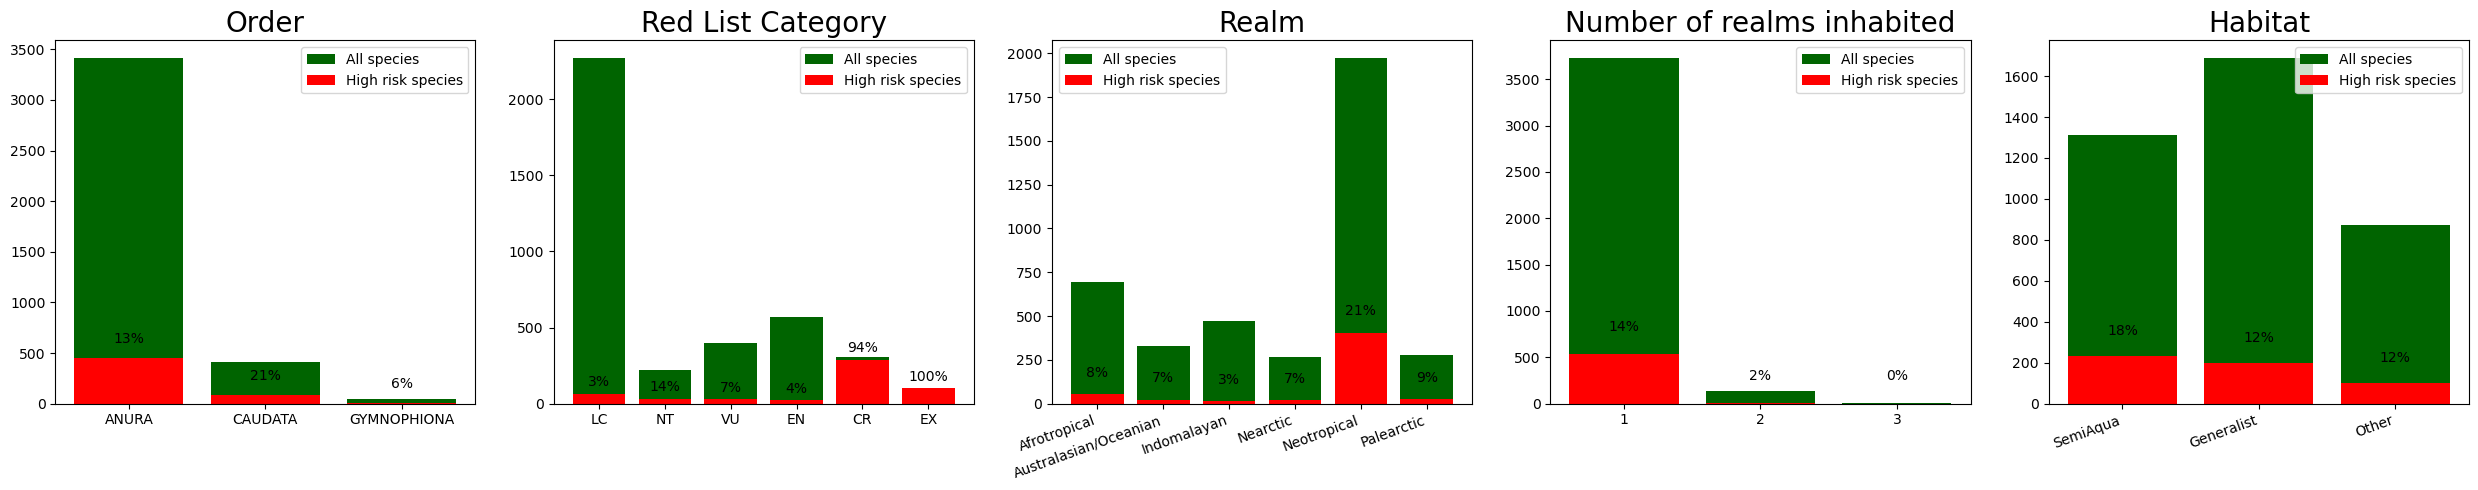

In [95]:
### View dataset ###

# define columns and rows
order_keys = ['sum red list category', 'ANURA', 'CAUDATA', 'GYMNOPHIONA']
categroy_keys = {0: 'SUM ORDER', 1: 'LC', 2: 'NT', 3: 'VU', 4: 'EN', 5: 'CR', 6: 'EX'}

# create pandas table with columns: order_keys and rows: category_keys keys
data_counts = pd.DataFrame(index=order_keys, columns=categroy_keys.values())
high_risk_counts = pd.DataFrame(index=order_keys, columns=categroy_keys.values())

# calculate counts
x_orders = {}
for i, ord in enumerate(order_keys):
    x_categories = {}
    for cat in range(1,7):
        x_ord_cat = x[(x['Order'] == ord) & (x['2004 RL num'] == cat)].drop(['Order', '2004 RL num'], axis=1)
        count = len(x_ord_cat)
        high_risk_count = x_ord_cat['higher risk'].sum()
        
        # store counts
        data_counts.loc[ord, categroy_keys[cat]] = count
        high_risk_counts.loc[ord, categroy_keys[cat]] = high_risk_count

# calculate sums
data_counts.loc['sum red list category'] = data_counts.sum(axis=0)
data_counts['SUM ORDER'] = data_counts.sum(axis=1)  

high_risk_counts.loc['sum red list category'] = high_risk_counts.sum(axis=0)
high_risk_counts['SUM ORDER'] = high_risk_counts.sum(axis=1)    
       
# print out the number of entries for each order and RL category
print('Entries per order and red list category (2004):')
display(data_counts)
print()

print('High risk entries per order and red list category (2004):')
display(high_risk_counts)
print()

# print varialbe names
var_names = x.keys()[13:]
print()
print('Data variables:')
for i in range(len(var_names)):
    print(f'{i+1}. {var_names[i]}')
print()

#####


# visualze composition of the dataset
print('Categorical variables (counts, high risk counts and percentage of high risk species):')

fig, axs = plt.subplots(1,5, figsize=(25, 5))
# barplot: order (counts and higher risk counts)
axs[0].bar(order_keys[1:], list(data_counts['SUM ORDER'].values)[1:], color='darkgreen', label='All species')
axs[0].bar(order_keys[1:], list(high_risk_counts['SUM ORDER'].values)[1:], color='red', label='High risk species')
# write text with percentage of high risk species on each bar
for i, ord in enumerate(order_keys[1:]):
    total = data_counts.loc[ord, 'SUM ORDER']
    high_risk = high_risk_counts.loc[ord, 'SUM ORDER']
    axs[0].text(i, high_risk+150, f'{round(high_risk/total*100)}%', color='black', ha='center')
axs[0].set_title('Order', fontsize=20)
# legend positioned at top right
axs[0].legend(loc='upper right')

# barplot: red list category (counts and higher risk counts)
axs[1].bar(list(categroy_keys.values())[1:], list(data_counts.loc['sum red list category'].values)[1:], color='darkgreen', label='All species')
axs[1].bar(list(categroy_keys.values())[1:], list(high_risk_counts.loc['sum red list category'].values)[1:], color='red', label='High risk species')
# write text with percentage of high risk species on each bar
for i, cat in enumerate(list(categroy_keys.values())[1:]):
    total = data_counts.loc['sum red list category', cat]
    high_risk = high_risk_counts.loc['sum red list category', cat]
    axs[1].text(i, high_risk+50, f'{round(high_risk/total*100)}%', color='black', ha='center')
axs[1].set_title('Red List Category', fontsize=20)
axs[1].legend()


# barplot: realm (counts and higher risk counts)
realm = {'Afrotropical': x['Afrotropical'].sum(), 'Australasian/Oceanian': x['Australasian/Oceanian'].sum(), 'Indomalayan': x['Indomalayan'].sum(), 'Nearctic': x['Nearctic'].sum(), 'Neotropical': x['Neotropical'].sum(), 'Palearctic': x['Palearctic'].sum()}
realm_high_risk = {'Afrotropical': x[x['higher risk'] == 1]['Afrotropical'].sum(), 'Australasian/Oceanian': x[x['higher risk'] == 1]['Australasian/Oceanian'].sum(), 'Indomalayan': x[x['higher risk'] == 1]['Indomalayan'].sum(), 'Nearctic': x[x['higher risk'] == 1]['Nearctic'].sum(), 'Neotropical': x[x['higher risk'] == 1]['Neotropical'].sum(), 'Palearctic': x[x['higher risk'] == 1]['Palearctic'].sum()}
axs[2].bar(realm.keys(), realm.values(), color= 'darkgreen', label='All species')
axs[2].bar(realm_high_risk.keys(), realm_high_risk.values(), color='red', label='High risk species')
axs[2].set_xticklabels(realm.keys(), rotation=20, horizontalalignment='right')
# write text with percentage of high risk species on each bar
for i, r in enumerate(realm.keys()):
    total = realm[r]
    high_risk = realm_high_risk[r]
    axs[2].text(i, high_risk+100, f'{round(high_risk/total*100)}%', color='black', ha='center')
axs[2].set_title('Realm', fontsize=20)
axs[2].legend()
_ = plt.tight_layout()

# histogram: 'N_realm'
nrealm_keys = x['N_realm'].unique()
nrealm = {key: len(x[x['N_realm'] == key]) for key in nrealm_keys}
nrealm_high_risk = {key: len(x[(x['N_realm'] == key) & (x['higher risk'] == 1)]) for key in nrealm_keys}
axs[3].bar(nrealm.keys(), nrealm.values(), color= 'darkgreen', label='All species')
axs[3].bar(nrealm_high_risk.keys(), nrealm_high_risk.values(), color='red', label='High risk species')
axs[3].set_xticks(nrealm_keys)
# write text with percentage of high risk species on each bar
for i, key in enumerate(nrealm_keys):
    total = nrealm[key]
    high_risk = nrealm_high_risk[key]
    axs[3].text(i+1, high_risk+250, f'{round(high_risk/total*100)}%', color='black', ha='center')
axs[3].set_title('Number of realms inhabited', fontsize=20)
axs[3].legend()


# barplot: 'SemiAqua', 'Generalist', 'Other'
habitat = {'SemiAqua': x['SemiAqua'].sum(), 'Generalist': x['Generalist'].sum(), 'Other': x['Other'].sum()}
habitat_high_risk = {'SemiAqua': x[x['higher risk'] == 1]['SemiAqua'].sum(), 'Generalist': x[x['higher risk'] == 1]['Generalist'].sum(), 'Other': x[x['higher risk'] == 1]['Other'].sum()}
axs[4].bar(habitat.keys(), habitat.values(), color= 'darkgreen', label='All species')
axs[4].bar(habitat_high_risk.keys(), habitat_high_risk.values(), color='red', label='High risk species')
axs[4].set_xticklabels(habitat.keys(), rotation=20, horizontalalignment='right')
# write text with percentage of high risk species on each bar
for i, hab in enumerate(habitat.keys()):
    total = habitat[hab]
    high_risk = habitat_high_risk[hab]
    axs[4].text(i, high_risk+100, f'{round(high_risk/total*100)}%', color='black', ha='center')
axs[4].set_title('Habitat', fontsize=20)
axs[4].legend()


# Define utils

In [96]:
# def updampling, downsampling 
def upsample(x, sm = SMOTENC(categorical_features=c_features), test_size = 0.3):
    '''
    Split into train and test set and then upsample. 
    The order is important, otherwise the test split is not really independent and there is guaranteed overfitting. 
    
    Parameters:
    x: pandas dataframe
    sm: upsampling method
    test_size: test size
    
    Returns:
    X_train_ups, X_test_ups, y_train_ups, y_test_ups
    '''
    # split into target variable and feature vector
    y = x['higher risk']
    X = x.drop(['higher risk'], axis=1)
    
    # split train test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
 
    # upsample
    try:
        X_train, y_train = sm.fit_resample(X_train, y_train)
        X_test, y_test = sm.fit_resample(X_test, y_test)
    except:
        try: 
            # SVMSMOTE requires six neighbours, if this does not work, use random oversampling
            # first for test set ...
            X_train, y_train = sm.fit_resample(X_train, y_train)
            X_test, y_test = sm.fit_resample(X_test, y_test)
        except:
            try: 
                # ... then for both
                sm = RandomOverSampler()
                X_train, y_train = sm.fit_resample(X_train, y_train)
                X_test, y_test = sm.fit_resample(X_test, y_test)
            except:
                # write none if upsampling fails
                X_train = np.array([None] * len(X_train))
                X_test = np.array([None] * len(X_test))
                y_train = np.array([None] * len(y_train))
                y_test = np.array([None] * len(y_test))
    
    
    return X_train, X_test, y_train, y_test

def downsample(x, test_size = 0.3):
    # split into target variable and feature vector
    y = x['higher risk']
    X = x.drop(['higher risk'], axis=1)
    
    # split train test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    def downsampleXy(X, y):
        # find minority class
        minority_class = y.value_counts().idxmin()
        
        # get number of positive samples and total samples
        nmin = y.value_counts()[minority_class]
        ntot = y.shape[0]

        # get indices of negative samples
        maj_indices = y[y != minority_class].index

        # select (ntot - 2 * nmin) random sample from negative samples to kick out
        # np.random.seed(42)
        try:
            indices_to_kickout = np.random.choice(maj_indices, ntot - 2 * nmin, replace=False)

            # resample X and y based on indices
            X = X.drop(indices_to_kickout)
            y = y.drop(indices_to_kickout)
            
        except: 
            # write none if upsampling fails
            X = np.array([None] * len(X))
            y = np.array([None] * len(y)) 
            
        return X, y
    
    X_train, y_train = downsampleXy(X_train, y_train)
    X_test, y_test = downsampleXy(X_test, y_test)
    
    return X_train, X_test, y_train, y_test

def sample(x, test_size = 0.3):
    # split into target variable and feature vector
    y = x['higher risk']
    X = x.drop(['higher risk'], axis=1)
    
    # split train test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    return X_train, X_test, y_train, y_test

In [97]:
# def trueskill score
from sklearn.metrics import confusion_matrix

# calculate TSS
def tss(y_test, y_pred, vocal=1):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensiticity = tp / (tp + fn)
    specitivity = tn / (fp + tn)
    tss = sensiticity + specitivity - 1

    if vocal == 2:
        print('Sensiticity (correctly positive): {0:0.4f}'. format(sensiticity))
        print('Specitivity (correctly negative): {0:0.4f}'. format(specitivity))
    if vocal in [1,2]:
        print('True Skill Score: {0:0.4f}'. format(tss))
        
    return tss
    

In [98]:
# create dataset splits

def get_dataset(x, sampling_function, split_type, cat_keys, vocal=0):
    
    if split_type == 'both':
        # split up the dataset for orders and categories
        splits = {'ANURA': {}, 'CAUDATA': {}, 'GYMNOPHIONA':{}}
        
        
        for ord in ['ANURA', 'CAUDATA', 'GYMNOPHIONA']:
            for cat in cat_keys:
                # get dataset for category
                xx = x[(x['Order'] == ord) & (x['2004 RL num'] == cat)].drop(['Order', '2004 RL num'], axis=1)
                
                X_train, X_test, y_train, y_test = sampling_function(xx)
                
                splits[ord][cat] = {
                    'X_train': X_train,
                    'X_test': X_test,
                    'y_train': y_train,
                    'y_test': y_test
                }
                
                if vocal == 1:
                    # if X_train contains None, print 'not enough data'
                    if None in X_train:
                        print(f'Order: {ord}, Category: {cat}, not enough data, positive samples in original dataset: {xx["higher risk"].sum()}')
                    else: 
                        print(f'Order: {ord}, Category: {cat}, train: {X_train.shape[0]}, test: {X_test.shape[0]}, positive samples in original dataset: {xx["higher risk"].sum()}')
            x_orders[ord] = x_categories
            
           
    if split_type == 'order':
        # split up the dataset for orders
        splits = {}
        for ord in ['ANURA', 'CAUDATA', 'GYMNOPHIONA']:
            xx = x[x['Order'] == ord].drop(['Order'], axis=1)
            X_train, X_test, y_train, y_test = sampling_function(xx)
            splits[ord] = {
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }
            
            if vocal == 1:
                # if X_train contains None, print 'not enough data'
                if None in X_train:
                    print(f'Order: {ord}, not enough data, positive samples in original dataset: {xx["higher risk"].sum()}')
                else: 
                    print(f'Order: {ord}, train: {X_train.shape[0]}, test: {X_test.shape[0]}, positive samples in original dataset: {xx["higher risk"].sum()}')
                    
    
    if split_type == 'category':
        splits = {}
        for cat in cat_keys:
            xx = x[x['2004 RL num'] == cat].drop(['2004 RL num'], axis=1)
            # convert order into numerical values
            order_dict = {'ANURA': 0, 'CAUDATA': 1, 'GYMNOPHIONA': 2}
            xx['Order'] = xx['Order'].map(order_dict)
            
            X_train, X_test, y_train, y_test = sampling_function(xx)
            splits[cat] = {
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }
            
            if vocal == 1:
                # if X_train contains None, print 'not enough data'
                if None in X_train:
                    print(f'Category: {cat}, not enough data, positive samples in original dataset: {xx["higher risk"].sum()}')
                else: 
                    print(f'Category: {cat}, train: {X_train.shape[0]}, test: {X_test.shape[0]}, positive samples in original dataset: {xx["higher risk"].sum()}')
                
    if split_type == 'none':
        # convert order into numerical values
        order_dict = {'ANURA': 0, 'CAUDATA': 1, 'GYMNOPHIONA': 2}
        xx = x.copy()
        xx['Order'] = xx['Order'].map(order_dict)
        
        X_train, X_test, y_train, y_test = sampling_function(xx)
        splits = {
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test
            }
        
        if vocal == 1:
            print(f'Train: {X_train.shape[0]}, test: {X_test.shape[0]}, positive samples in original dataset: {x["higher risk"].sum()}')
            
    return splits

# Experiment 1
## Importance of climate compared to other variables (e.g. landuse)

**Overview**
1. Train a random forest classifier on a balanced dataset
2. Cluster variables based on corellation
3. Measure the variable importance for different supsets of variables

In [102]:
### Prepare data for fitting ###

# convert order into numerical values
order_dict = {'ANURA': 0, 'CAUDATA': 1, 'GYMNOPHIONA': 2}
xx = x.copy()
xx['Order'] = xx['Order'].map(order_dict)

# drop area
xx = xx.drop(['area_2021'], axis=1)

# split into target variable and feature vector
y = xx['higher risk']
X = xx.drop(['higher risk'], axis=1)
    
# split train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=20)

# upsample using SMOTENC with can hanle continuous and categorical variables
sm = SMOTENC(random_state=20, categorical_features=c_features)
X_train, y_train = sm.fit_resample(X_train, y_train)
# X_test, y_test = sm.fit_resample(X_test, y_test)

# store RL num seperately and then drop it
X_train_cat = X_train[['2004 RL num']]
X_test_cat = X_test[['2004 RL num']]
X_train.drop(['2004 RL num'], axis=1, inplace=True)
X_test.drop(['2004 RL num'], axis=1, inplace=True)

In [103]:
### Fit random forest model ###

# initialize RF        
rfc = RandomForestClassifier(n_estimators=100, max_features= 14, min_samples_leaf=5,
                    min_impurity_decrease= 0.0002, random_state=20)

# # alternative: SVM
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# rfc = make_pipeline(StandardScaler(), SVC(gamma='auto'))

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

# Check the performance of the model
true_skill_scores = tss(y_test, y_pred, vocal=2)

Sensiticity (correctly positive): 0.5091
Specitivity (correctly negative): 0.9359
True Skill Score: 0.4450


In [101]:
# split test set into different categories
cat_keys = [1, 2, 3, 4, 5]
X_test_cats = {}	
y_test_cats = {}
for cat in cat_keys:
    X_test_cats[cat] = X_test[X_test_cat['2004 RL num'] == cat]
    y_test_cats[cat] = y_test[X_test_cat['2004 RL num'] == cat]
    
# predict for each category
y_pred_cats = {}
for cat in cat_keys:
    y_pred_cats[cat] = rfc.predict(X_test_cats[cat])
    
# calculate TSS for each category
tss_cats = {}
for cat in cat_keys:
    print(f'Category {cat}:')
    print('positives in test set:', y_test_cats[cat].sum())
    print('negatives in test set:', len(y_test_cats[cat]) - y_test_cats[cat].sum())
    tss_cats[cat] = tss(y_test_cats[cat], y_pred_cats[cat], vocal=2)
    print('-----------------')

Category 1:
positives in test set: 112
negatives in test set: 639
Sensiticity (correctly positive): 0.7411
Specitivity (correctly negative): 0.9906
True Skill Score: 0.7317
-----------------
Category 2:
positives in test set: 5
negatives in test set: 64
Sensiticity (correctly positive): 0.6000
Specitivity (correctly negative): 1.0000
True Skill Score: 0.6000
-----------------
Category 3:
positives in test set: 27
negatives in test set: 121
Sensiticity (correctly positive): 0.8148
Specitivity (correctly negative): 0.8678
True Skill Score: 0.6826
-----------------
Category 4:
positives in test set: 23
negatives in test set: 166
Sensiticity (correctly positive): 0.9130
Specitivity (correctly negative): 0.7831
True Skill Score: 0.6962
-----------------
Category 5:
positives in test set: 694
negatives in test set: 8
Sensiticity (correctly positive): 0.7925
Specitivity (correctly negative): 0.2500
True Skill Score: 0.0425
-----------------


The high model shows high skill measure in predicting the balanced test data. 
- remains high when spliting into categories (cat var has been left out before, since otherwise, cat 5 would have been enough to classify as 'high risk')
- Note that it is not good for prediction since model skill highly relies on a balanced dataset (results not shown here, TSS=0.2)

In [82]:
# plot permutation importance
from sklearn.inspection import permutation_importance


def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()[::-1]
    # forest_importances = pd.Series(result.importances_mean, index=X_train.columns).sort_values(ascending=False)

    # make x axis log scale
    sns.barplot(
        x = result.importances_mean[perm_sorted_idx].T,
        xerr = result.importances_std[perm_sorted_idx].T,
        y = X.columns[perm_sorted_idx],
        ax=ax
        
    )
    
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

True Skill Score: 0.7916


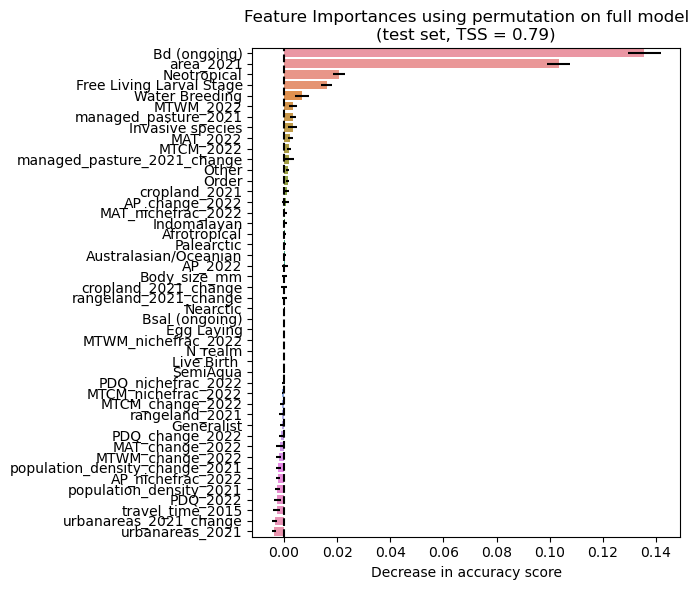

In [83]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(rfc, X_test, y_test, ax)
ax.set_title("Feature Importances using permutation on full model\n(test set, TSS = {})".format(np.round(tss(y_test, y_pred), 2)))
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

In this plot, the errorbars only reflect the variation umong trees within the random forest. The uncertainty from sampling is not taken into account for now.

We can see that the Order (Annura, Caudata, Cymnophiona) does not seem to have such a big influence on the classification as other variables. In contrast, the categorical variables for realm (e.g. Neotropical) and habitat (e.g. Other, Generalist) seem to be more important.

The interesting question is if this is simply because of a higher 'higher risk' base rate umong the species living in south america (Neotropical), if they generally have a higher exposure or if these species actually react differently to external influences. Similarly for species within different habitats.

## Handle multicollinear features
Following [skikit learn documentation](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py)

In [53]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

# X = X_test_ups
# y = y_test_ups


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_train.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
ax1.set_title("Dendrogram of hierarchical clustering of features", fontsize=14)

ax2.imshow(distance_matrix[dendro["leaves"], :][:, dendro["leaves"]])
# add colorbar with cmap='gist_heat_r'
cbar = plt.colorbar(ax2.imshow(distance_matrix[dendro["leaves"], :][:, dendro["leaves"]], cmap='gist_heat'), ax=ax2)
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
ax2.set_title("Distance matrix of features", fontsize=14)
_ = fig.tight_layout()

**Hirarchical clustering** \
(see [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage))


**Hirarchical dendogram (left)** \
The top of the U-link indicates a cluster merge. The two legs of the U-link indicate which clusters were merged. The length of the two legs of the U-link represents the distance between the child clusters. It is also the cophenetic distance between original observations in the two children clusters.



### Calculating new RF and feature importances on balanced dataset

In [54]:
from collections import defaultdict
from sklearn.inspection import permutation_importance

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
# for each cluster, select the feature with the highest permutation importance in the full model
selected_features = []
result = permutation_importance(rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
for idx, feature_ids in cluster_id_to_feature_ids.items():
    best_feature = None
    best_importance = 0
    for feature_id in feature_ids:
        importance = result.importances_mean[feature_id]
        if importance > best_importance:
            best_importance = importance
            best_feature = feature_id
    selected_features.append(best_feature)
# clear None values (if any)
selected_features = [x for x in selected_features if x is not None]
selected_features_names = X_test.columns[selected_features]
    
# selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]selected_features_names = X.columns[selected_features]

# select other features!
# selected_features_names = ['cropland_2021_change', 'Neotropical', 'rangeland_2021', 'Generalist', 'population_density_2021', 'AP_nichefrac_2022']

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

In [55]:
# train RF

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_leaf=5)
clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)
print()
tss_sel = tss(y_test, clf_sel.predict(X_test_sel), vocal=True)

Baseline accuracy on test data with features removed: 0.88

True Skill Score: 0.7556


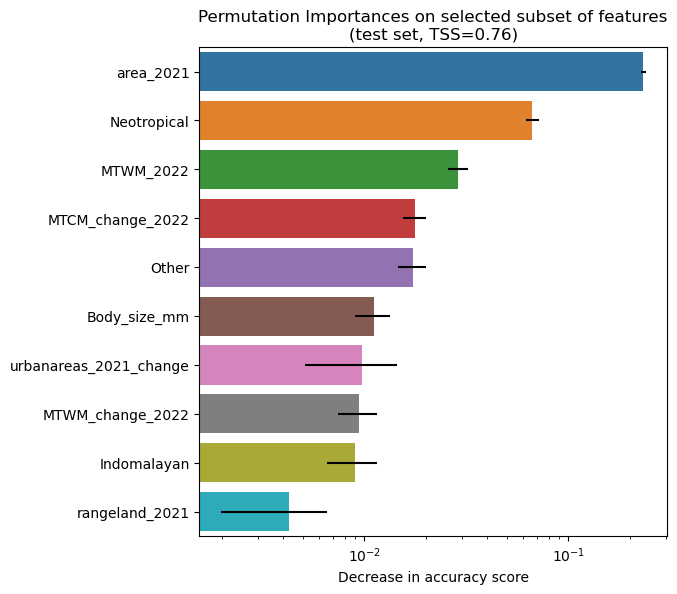

In [60]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set, TSS={})".format(np.round(tss_sel, 2)))
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
# ax.set_xlim(-0.02, 0.07)
ax.set_xscale('log')
plt.show()

This is an interesting set of variables that we can use for setting up our reduced model.

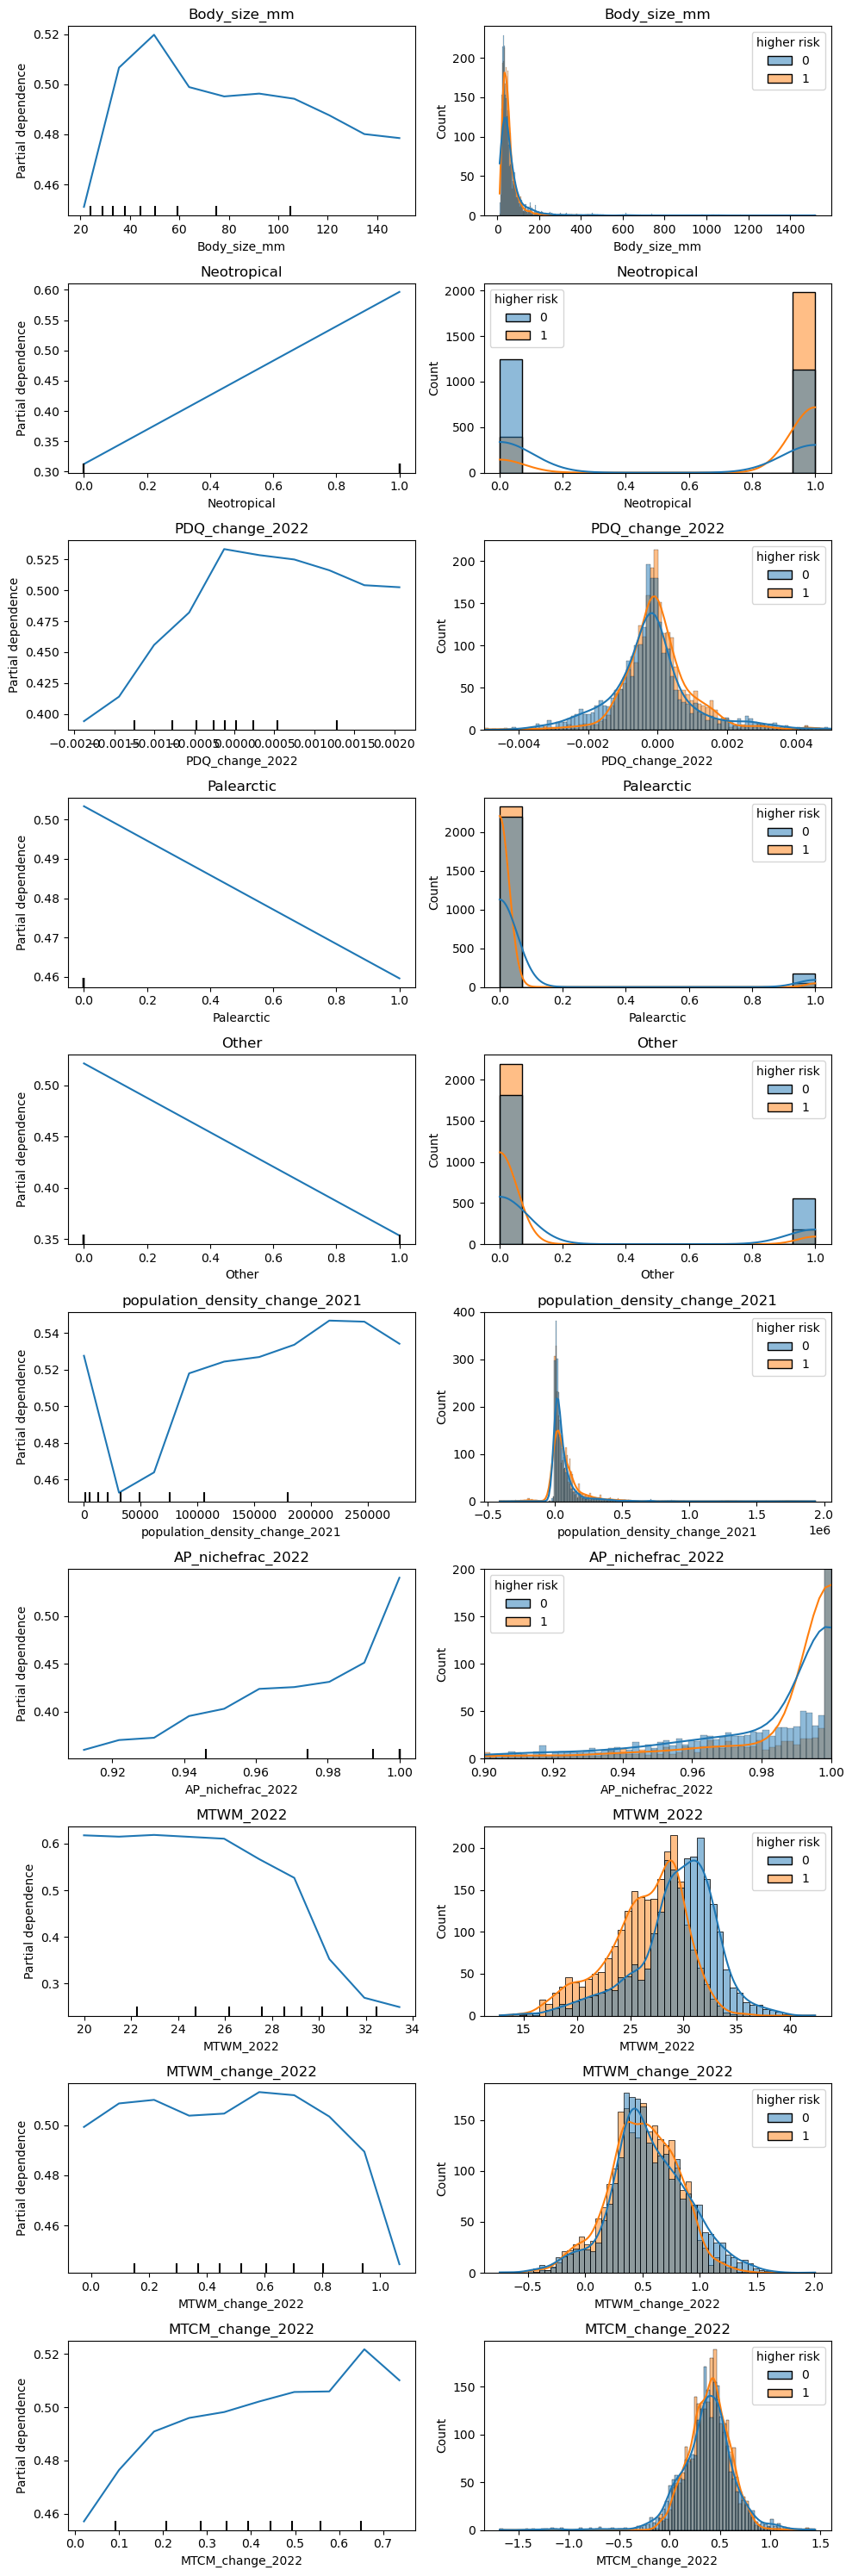

In [44]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
n_features = len(selected_features_names)
features = np.arange(n_features)
fig, ax = plt.subplots(n_features, 2, figsize=(10, 30))
for i in features:
    PartialDependenceDisplay.from_estimator(clf_sel, X_train_sel, [i], grid_resolution=10, ax=ax[i,0,])
    ax[i,0].set_title(selected_features_names[i])
    # ax[i].set_ylabel("Partial dependence")
    # ax[i].set_xlabel('')
    ax[i,0].figure.tight_layout()
    
    sns.histplot(data=X_train_sel, x=selected_features_names[i], hue=y_train, kde=True, ax=ax[i,1])
    ax[i,1].set_title(selected_features_names[i])
    if selected_features_names[i] == 'rangeland_2021_change':
        ax[i,1].set_xlim([-0.03,0.03])
        ax[i,1].set_ylim([0, 200])
        
    if selected_features_names[i] == 'PDQ_change_2022':
        ax[i,1].set_xlim([-0.005, 0.005])
        # ax[i,1].set_ylim([0, 200])
        
    if selected_features_names[i] == 'population_density_2021':
        ax[i,1].set_xlim([0,0.2 * 1e7])
        ax[i,1].set_ylim([0, 300])
        
    if selected_features_names[i] == 'AP_nichefrac_2022':
        ax[i,1].set_xlim([0.9,1])
        ax[i,1].set_ylim([0, 200])

obtain pred_func from the provided model.


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 29.90it/s]


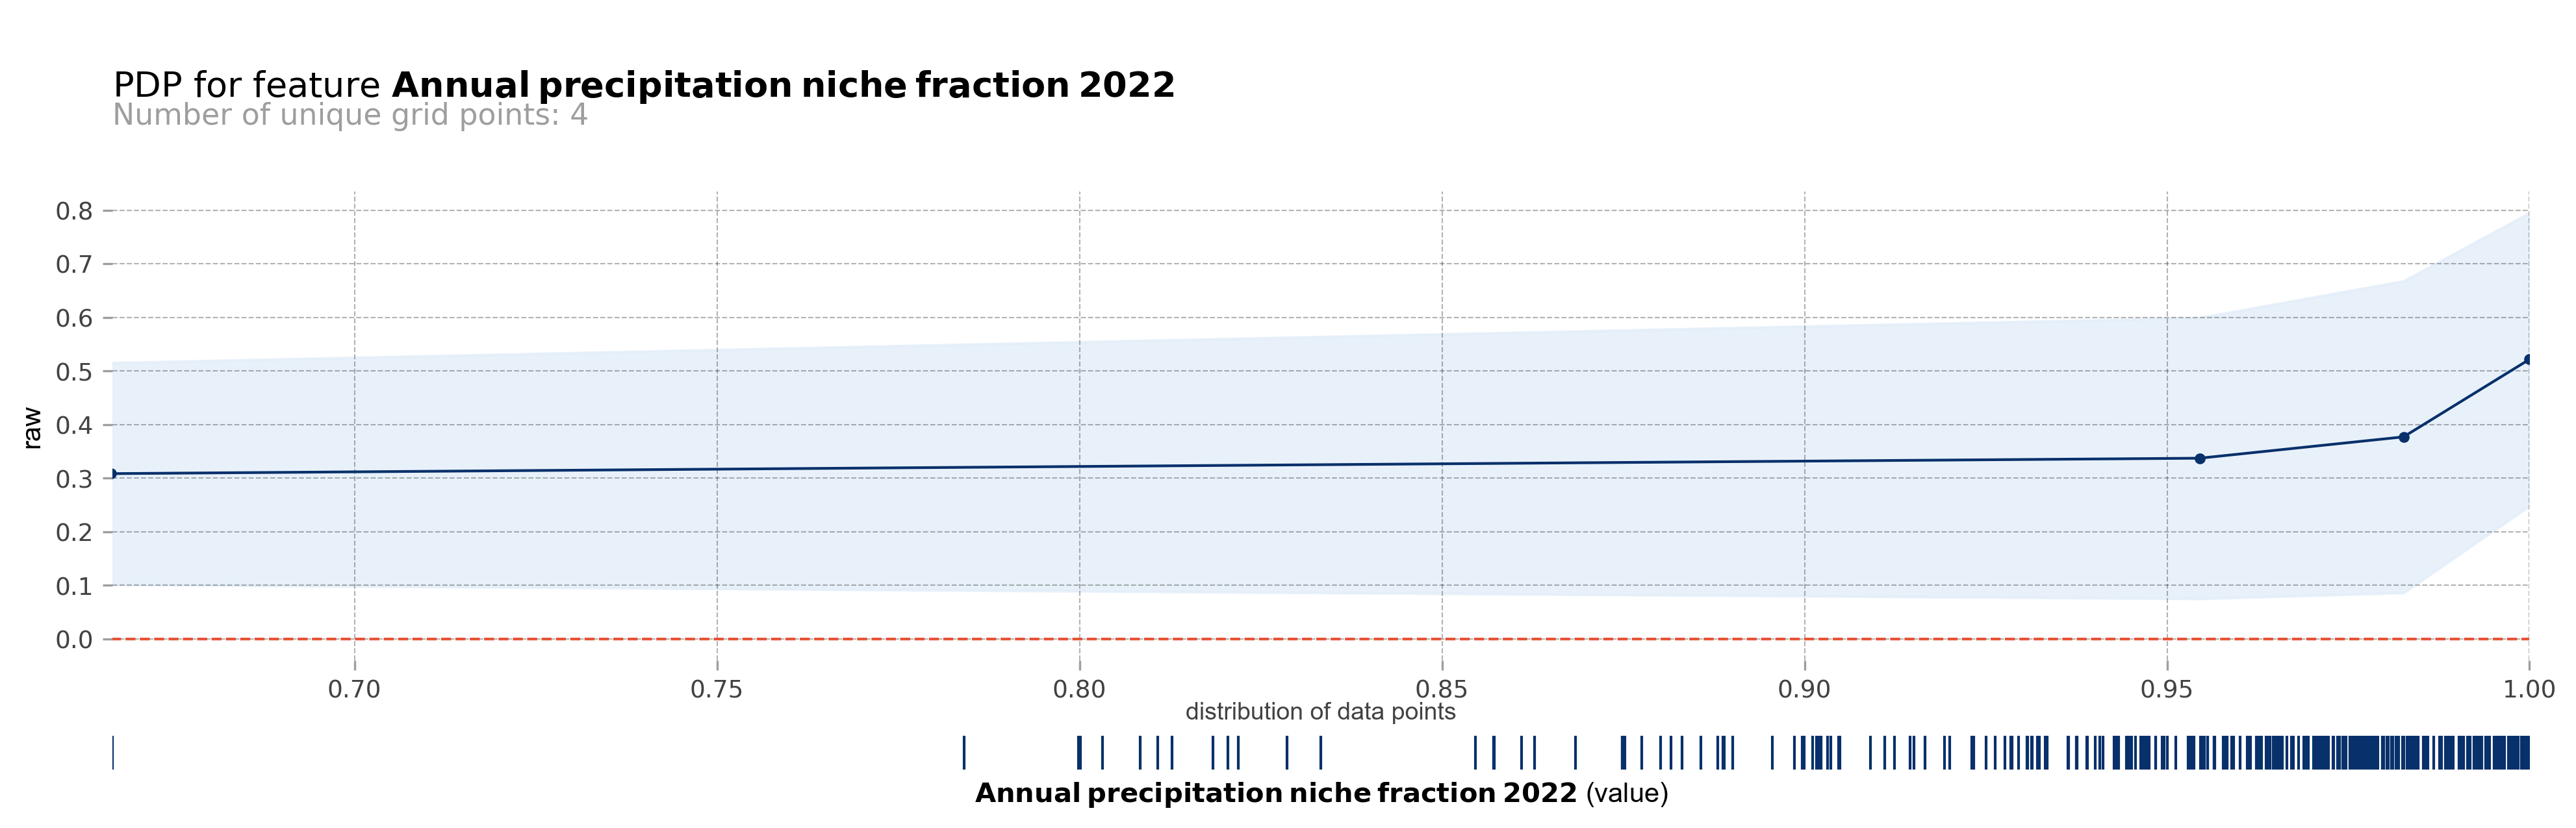

In [55]:
# from sklearn.inspection import PartialDependenceDisplay
# features = [3, 7]
# PartialDependenceDisplay.from_estimator(clf_sel, X_train_sel, features, grid_resolution=20, kind='both')
from pdpbox import pdp


pdp_AP_niche = pdp.PDPIsolate(
    model=clf_sel,
    df=pd.concat([X_test_sel, y_test], axis=1),
    model_features=X_test_sel.columns, 
    feature='AP_nichefrac_2022',
    feature_name="Annual\: precipitation\: niche\: fraction\: 2022",
)

# plot 
fig, axes = pdp_AP_niche.plot(
    center=False,
    plot_lines=False,
    plot_pts_dist=True,
    to_bins=False,
    engine='matplotlib',
    
)
fig.set_figheight(5)

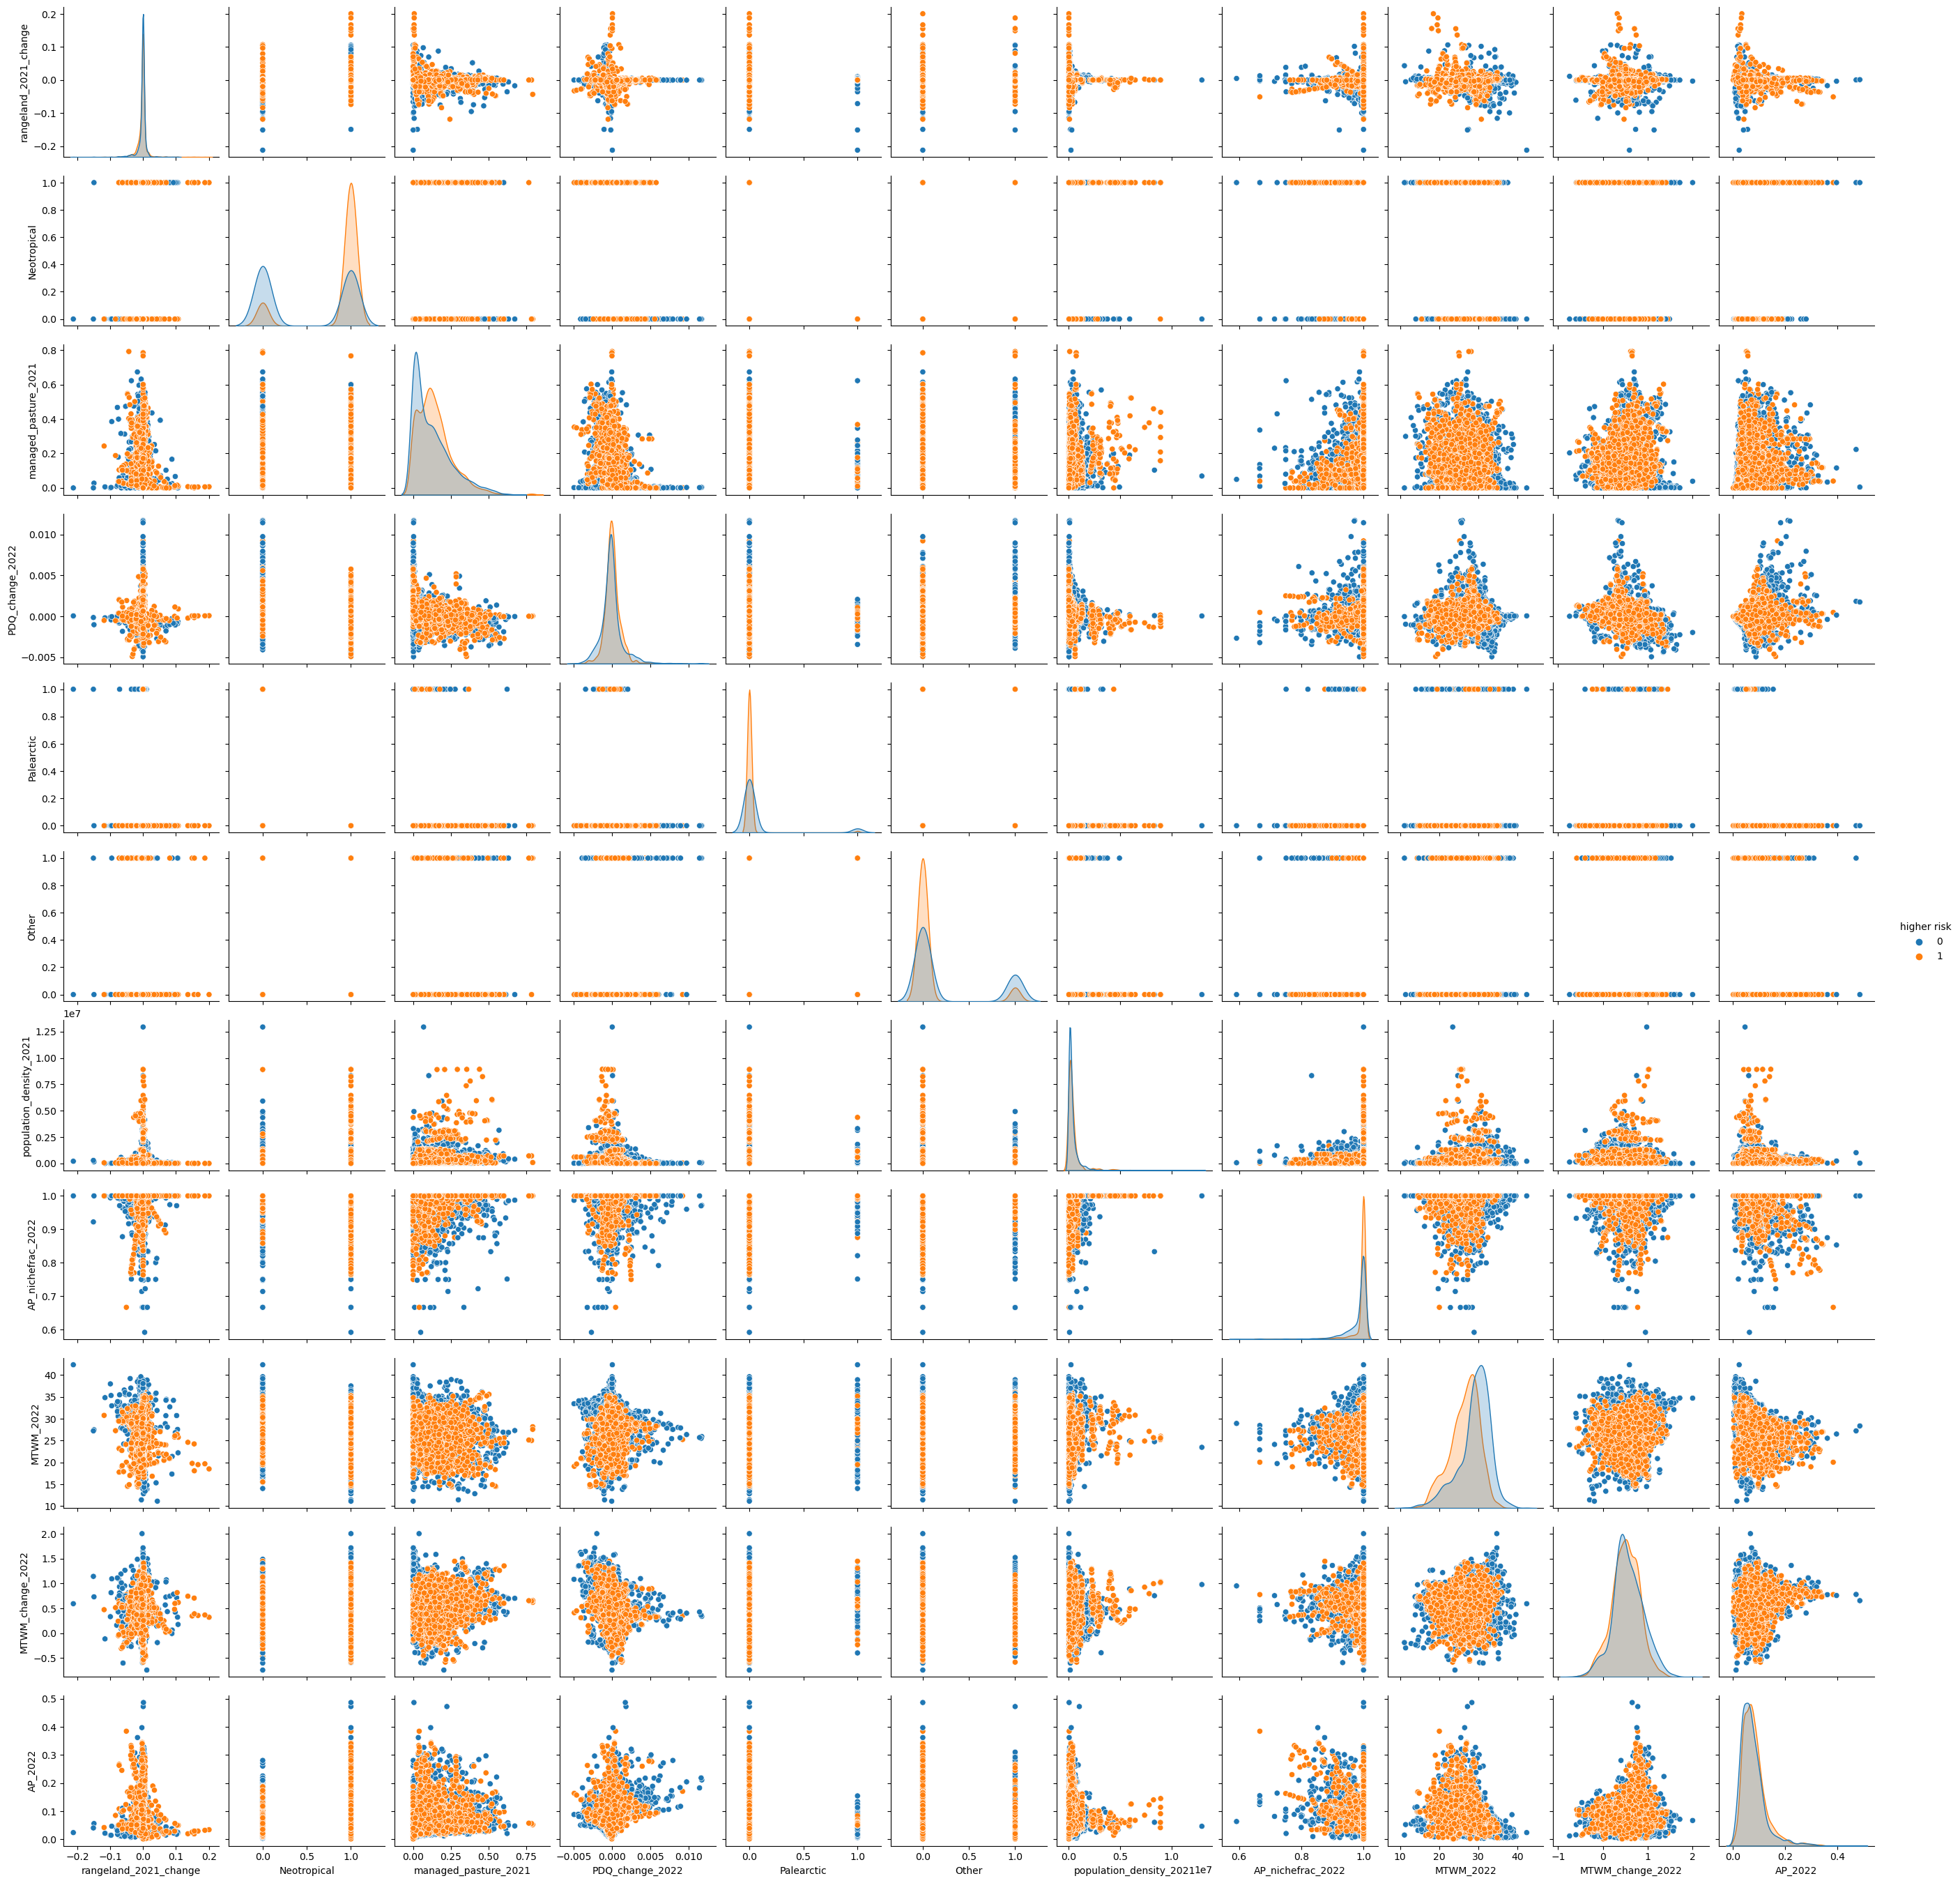

In [116]:
# use seaborn to plot two variable point clouds for X_train_sel
sns.pairplot(data=pd.concat([X_train_sel, y_train], axis=1), hue='higher risk', vars=selected_features_names, diag_kind='kde')

IndexError: index 30 is out of bounds for axis 0 with size 30

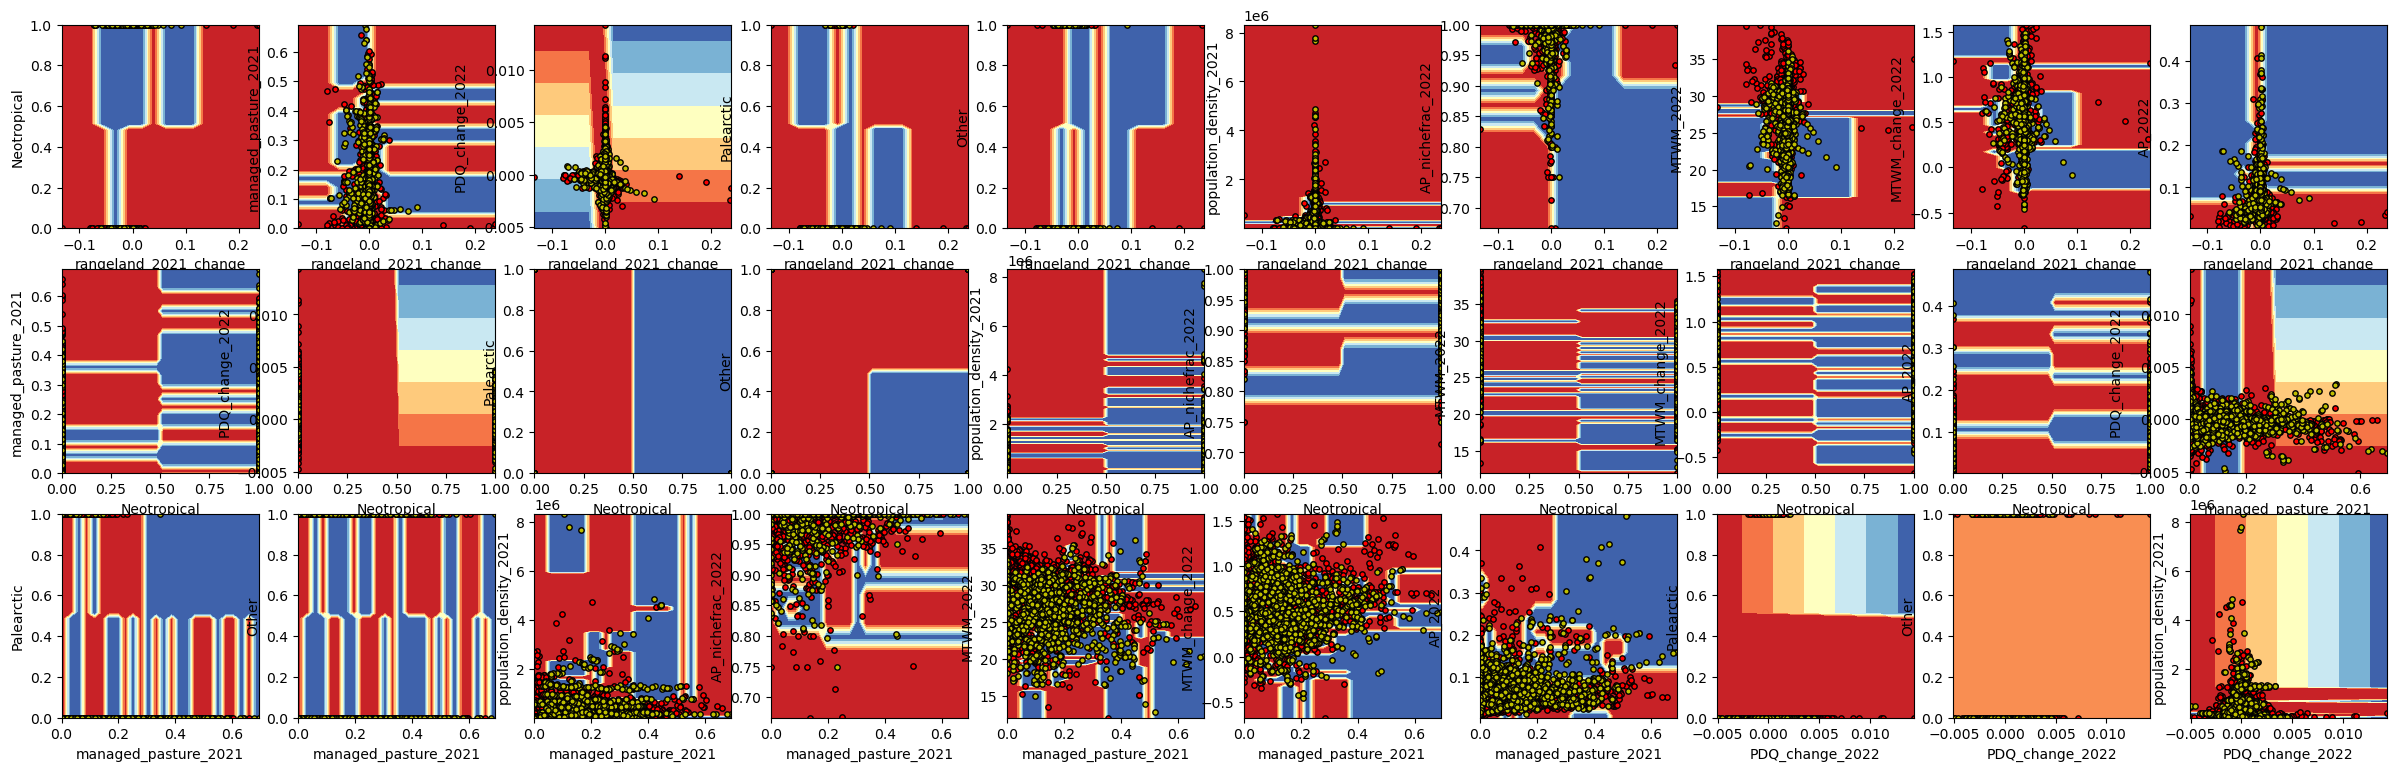

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = len(np.unique(y_test))
plot_colors = "ryb"
plot_step = 0.02

# Convert pandas DataFrame to numpy array
X_test_sel_np = X_test_sel.to_numpy()
y_test_np = y_test.to_numpy()

# Get feature pairs
feature_pairs = [[i, j] for i in range(X_test_sel_np.shape[1]) for j in range(i+1, X_test_sel_np.shape[1])]

# Set the figsize for the whole plot
fig, axs = plt.subplots(3, 10, figsize=(30, 9))

for pairidx, pair in enumerate(feature_pairs):
    # We only take the two corresponding features
    X = X_test_sel_np[:, pair]
    y = y_test_np

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    ax = axs.flatten()[pairidx]  # Access the correct subplot
    display = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
        xlabel=X_test_sel.columns[pair[0]],
        ylabel=X_test_sel.columns[pair[1]],
    )
    
    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        ax.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            label=i,
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )
    
    # Set x and y limits based on the training points
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    ax.set_xlim(max(xlim[0], x_min), min(xlim[1], x_max))
    ax.set_ylim(max(ylim[0], y_min), min(ylim[1], y_max))

fig.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout, leaving space for the title
plt.show()
